In [16]:
import matplotlib.pyplot as plt
from imageio import imread
from tqdm import tqdm
import numpy as np
plt.rcParams.update({'font.size':16})

#### Cross-validation for Ridge and Lasso regression on Franke function

In [21]:
from Project1b import make_Franke
from Project1d import kfold
from Project1e import Bootstrap_pred as Bootstrap_pred_Ridge
from Project1f import Bootstrap_pred as Bootstrap_pred_Lasso
from Project1e import fit_Ridge
from Project1f import fit_Lasso

def contour_plots_CV(fit_method):

    ### Defining input parameters
    n_degrees = 20                     # number of degrees, degrees 0 ... n_degrees-1
    nk = 4                             # number of k-folds
    lambdas = np.logspace(-12, -1, 20) # values of lambda to use in Ridge regression

    nx, ny = (20, 20)
    x, y, z = make_Franke(nx, ny, noise=0.1, seed=0)

    ### Making dataset
    learn_set, test_set = kfold(x, y, z, nk, seed=0)

    bias_ = []
    variance_ = []
    error_ = []

    ### Looping over lambdas, each generating a set of bias/variance/error curves
    for i, lam in tqdm(enumerate(lambdas)):
        bias     = np.zeros(n_degrees)
        variance = np.zeros(n_degrees)
        error    = np.zeros(n_degrees)

        ### Looping over k-folds, using a different combination each time
        for k in range(nk):
            x_lk, y_lk, z_lk = learn_set[:, k] # x,y,z for learn set nr. k
            x_tk, y_tk, z_tk =  test_set[:, k] # x,y,z for test set

            # Performing n_bootstraps resamplings of learn set and resulting n_degrees models to each test set
            # Functions for Ridge and Lasso do not return arrays of same shape...

            if fit_method=='Ridge':
                z_pred = fit_Ridge(np.arange(n_degrees), lam, x_lk, y_lk, z_lk, x_tk, y_tk, z_tk)[-1]
                z_pred = np.array([z_pred[i] for i in range(n_degrees)])[:, :, np.newaxis]

            else:
                z_pred = fit_Lasso(np.arange(n_degrees), lam, x_lk, y_lk, z_lk, x_tk, y_tk, z_tk)
                z_pred = np.array([z_pred[i] for i in range(n_degrees)])[:, :, np.newaxis]

            # Finding how well each model fits across all bootstraps, doing running average over all k-folds
            for degree in range(n_degrees): #         Broadcasting ↓   Axis with bootstrapped values ↓
                error[degree]    += np.mean( np.mean((z_tk[:, np.newaxis] - z_pred[degree])**2, axis=1, keepdims=True) ) / nk # <- Note division by nk to
                bias[degree]     += np.mean( (z_tk[:, np.newaxis] - np.mean(z_pred[degree], axis=1, keepdims=True))**2 ) / nk #    get a running average
                variance[degree] += np.mean( np.var(z_pred[degree], axis=1, keepdims=True) ) / nk

        bias_.append(bias)
        variance_.append(variance)
        error_.append(error)
        
    degrees = np.arange(n_degrees)
    extent = [degrees[0], degrees[-1], np.log10(lambdas[0]), np.log10(lambdas[-1])]

    figname = lambda name: f"fig/{name}_{0}-{n_degrees-1}_{nx}x{ny}.pdf"

    plt.contourf(np.log10(error_), extent=extent, levels=30)
    ix, iy = np.where(np.min(error_) == error_)
    print("{}, CV, MSE min = {}".format(fit_method, np.min(error_)))
    plt.plot(degrees[iy], np.log10(lambdas[ix]), 'rx', label=r'pol. degree = %.i, $\lambda$ = %.2e' % (degrees[iy], lambdas[ix]))
    plt.xticks(degrees[::2])
    plt.title(f"{fit_method} regression with CV")
    plt.xlabel("Polynomial degree")
    plt.ylabel(r"log$_{10}$($\lambda$)")
    plt.legend()
    plt.colorbar(label=r"log$_{10}$(MSE)")
    plt.tight_layout()
    figure = plt.gcf()
    figure.set_size_inches(8.3, 6)
    plt.savefig(figname(f"MSE_Franke_{fit_method}_CV"), format="pdf")
    plt.show();

20it [00:14,  1.35it/s]


Ridge, CV, MSE min = 0.002108191114487902


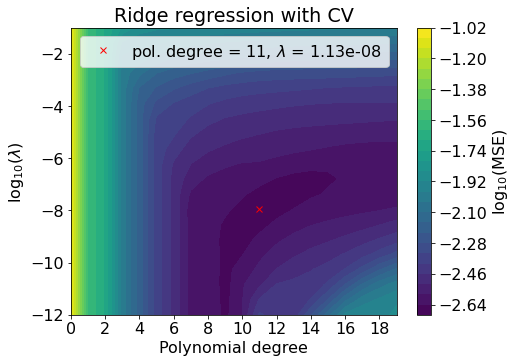

20it [00:33,  1.68s/it]


Lasso, CV, MSE min = 0.006490695793288948


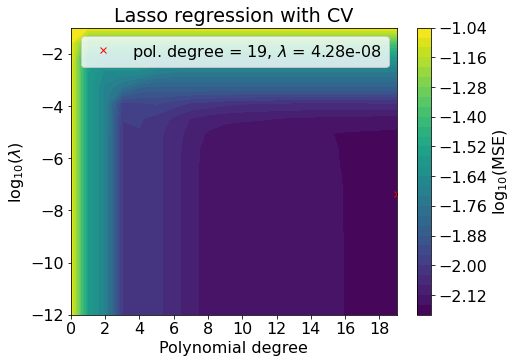

In [22]:
contour_plots_CV("Ridge")
contour_plots_CV("Lasso")

#### Bootstrap for Ridge and Lasso regression on Franke function

In [23]:
from Project1b import make_Franke, create_X
from Project1c import Bootstrap
from Project1e import Bootstrap_pred as Bootstrap_pred_Ridge
from Project1f import Bootstrap_pred as Bootstrap_pred_Lasso
from Project1e import fit_Ridge
from Project1f import fit_Lasso
from sklearn.model_selection import train_test_split

def contour_plots_Bootstrap(fit_method):

    ### Defining input parameters
    n_degrees = 20                     # number of degrees, degrees 0 ... n_degrees-1
    nk = 4                             # number of k-folds
    n_bootstraps = 10                  # number of times to resample each learn-set
    lambdas = np.logspace(-12, -1, 20)  # values of lambda to use in Ridge regression

    nx, ny = (20, 20)
    x, y, z = make_Franke(nx, ny, noise=0.1, seed=0)

    x = x.flatten()
    y = y.flatten()
    z = z.flatten()

    ### Making dataset
    x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2, random_state=0)

    bias_ = []
    variance_ = []
    error_ = []

    ### Looping over lambdas, each generating a set of bias/variance/error curves
    for i, lam in tqdm(enumerate(lambdas)):
        bias     = np.zeros(n_degrees)
        variance = np.zeros(n_degrees)
        error    = np.zeros(n_degrees)

        if fit_method=="Ridge":
            # Performing n_bootstraps resamplings of learn set and resulting n_degrees models to each test set
            z_pred = Bootstrap_pred_Ridge(x_train, x_test, y_train, y_test, z_train, z_test, n_bootstraps, n_degrees, lam) # <- Note lambda is input here
        else:
            z_pred = Bootstrap_pred_Lasso(x_train, x_test, y_train, y_test, z_train, z_test, n_bootstraps, n_degrees, lam) # <- Note lambda is input here
            
        # Finding how well each model fits across all bootstraps, doing running average over all k-folds
        for degree in range(n_degrees): #         Broadcasting ↓   Axis with bootstrapped values ↓
            error[degree]    += np.mean( np.mean((z_test[:, np.newaxis] - z_pred[degree])**2, axis=1, keepdims=True) ) / nk # <- Note division by nk to
            bias[degree]     += np.mean( (z_test[:, np.newaxis] - np.mean(z_pred[degree], axis=1, keepdims=True))**2 ) / nk #    get a running average
            variance[degree] += np.mean( np.var(z_pred[degree], axis=1, keepdims=True) ) / nk

        bias_.append(bias)
        variance_.append(variance)
        error_.append(error)
        
    error_ = np.array(error_)

    plt.rcParams.update({'font.size':16})

    degrees = np.arange(n_degrees)
    extent = [degrees[0], degrees[-1], np.log10(lambdas[0]), np.log10(lambdas[-1])]

    figname = lambda name: f"fig/{name}_{0}-{n_degrees-1}_{nx}x{ny}.pdf"

    plt.contourf(np.log10(error_), extent=extent, levels=30)
    ix, iy = np.where(np.min(error_) == error_)
    print("{}, bootstrap, MSE min = {}".format(fit_method, np.min(error_)))
    plt.plot(degrees[iy], np.log10(lambdas[ix]), 'rx', label=r'pol. degree = %.i, $\lambda$ = %.2e' % (degrees[iy], lambdas[ix]))
    plt.xticks(degrees[::2])
    plt.title(f"{fit_method} regression with Bootstrap")
    plt.xlabel("Polynomial degree")
    plt.ylabel(r"log$_{10}$($\lambda$)")
    plt.legend()
    plt.colorbar(label=r"log$_{10}$(MSE)")
    plt.tight_layout()
    figure = plt.gcf()
    figure.set_size_inches(8.3, 6)
    plt.savefig(figname(f"MSE_Franke_{fit_method}_bootstrap"), format="pdf")
    plt.show()

20it [00:27,  1.37s/it]


Ridge, bootstrap, MSE min = 0.0006797025626968885


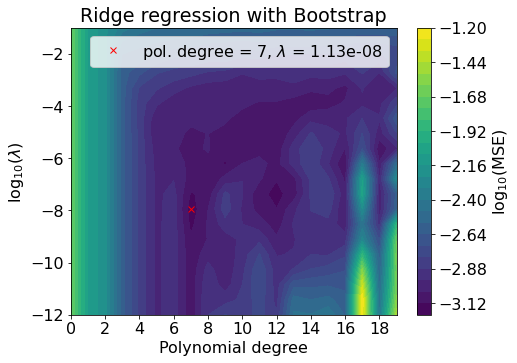

20it [01:12,  3.64s/it]


Lasso, bootstrap, MSE min = 0.0016949730609659714


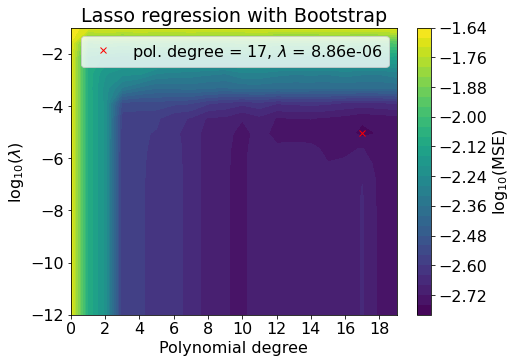

In [24]:
contour_plots_Bootstrap("Ridge")
contour_plots_Bootstrap("Lasso")